<font size="6"> **ML-Sentiment Factor in SEC 10-K Fillings** </font>

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%run ../nb_config.py

In [4]:
import nltk
import numpy as np
import pandas as pd
import scipy
import pickle
import datetime as dt

import os

from tqdm import tqdm

In [8]:
from src import utils
from src.mle_quant_utils import mle_utils
from src.load_data import load_sec10k, io_utils
from src.nlp_quant import bow_sent

In [6]:
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectPercentile, mutual_info_classif

from sklearn import metrics

In [7]:
cfg = utils.read_conf()

In [8]:
INPATH1 = os.path.join(io_utils.interim_path, 'sec_fillings', '')
INPATH2 = os.path.join(io_utils.raw_path, 'market_data', cfg['quantopian']['dataset4']['folder'],'')
INPATH3 =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(INPATH1), os.path.isdir(INPATH2), os.path.isdir(INPATH3)

(True, True, True)

In [11]:
INFILE1 = 'metadata.pkl'
INFILE2 = 'tenks_risk_tfidf_by_sent.pkl'
INFILE3 =  'parsed_sentiment_loughran_mcdonald.csv'
INFILE4 =  'tenks_risk_doc_len.csv'
INFILE5 = cfg['quantopian']['dataset4']['prices']
INFILE6 = cfg['output']['interim']['sector_factors']
INFILE7 = cfg['output']['interim']['pricing']
INFILE8 = 'sec_10k_loughran_sent_alpha.csv'

In [12]:
OUTPATH =  os.path.join(io_utils.processed_path, 'sec_fillings', '')
os.path.isdir(OUTPATH)

True

In [13]:
OUTFILE1 = 'sec_10k_mlbow_sent_alpha.csv'
FLG_OUTPUT = False  # Write predictions

In [14]:
example_ticker = 'amzn'

In [15]:
START_DT = '1998'
END_DT = '2018'
train_test_split_yr = '2013-12-31'
KFOLDS = 3
RND_SEED = 123

# Load Data

## Corpus Data

In [16]:
with open(INPATH1 + INFILE1, 'rb') as file:
    metadata = pickle.load(file)

In [17]:
tf_idf_by_sent = bow_sent.read_sent_tfidf_dict(path=INPATH1, name=INFILE2)

In [18]:
tf_idf_by_sent.keys()

dict_keys(['negative', 'positive', 'uncertainty', 'litigious', 'constraining', 'interesting'])

In [19]:
tf_idf_by_sent['negative'].iloc[0:2,0:10]

abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                   
aal    2003-04-15      0.0          0.0           0.0       0.0         0.0   
       2004-02-27      0.0          0.0           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-04-15          0.0       0.0         0.0           0.0   
       2004-02-27          0.0       0.0         0.0           0.0   

                   aberrations  
ticker date                     
aal    2003-04-15          0.0  
       2004-02-27          0.0

In [20]:
tf_idf_by_sent['negative'].iloc[:5,0]  # underlying pandas is an sparse data structure

ticker  date      
aal     2003-04-15    0.0
        2004-02-27    0.0
        2005-02-25    0.0
        2006-02-24    0.0
        2007-02-23    0.0
Name: abandon, dtype: Sparse[float64, 0.0]

In [21]:
doc_lens = pd.read_csv(INPATH1 + INFILE4, parse_dates=['date'], index_col=[0,1])['doc_len']

## Sentiemnts Metadata

In [22]:
sentiment_df =  pd.read_csv(INPATH1 + INFILE3)

## Prices

In [23]:
# Yearly pricing
pricing_yr = pd.read_csv(INPATH2 + INFILE5, parse_dates=['date'])
pricing_yr = pricing_yr.pivot(index='date', columns='ticker', values='adj_close')
pricing_yr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 57 entries, 1962-01-01 to 2018-01-01
Columns: 11941 entries, A to ZZZ
dtypes: float64(11941)
memory usage: 5.2 MB


In [24]:
pd.concat([pricing_yr.head(2), pricing_yr.tail(2)], axis=0)

ticker,A,AA,AAAP,AABA,AAC,AADR,AAIT,AAL,AAMC,AAME,AAN,AAOI,AAON,AAP,AAPC,AAPL,AAT,AAU,AAV,AAVL,AAWW,AAXJ,AAXN,AA_P_B,AA_W,...,ZOES,ZOM,ZOOM,ZPIN,ZQK,ZROZ,ZS,ZSAN,ZSL,ZSML,ZSPH,ZTO,ZTR,ZTS,ZU,ZUMZ,ZUO,ZVZZC,ZVZZCNX,ZX,ZXYZ_A,ZYME,ZYNE,ZZK,ZZZ
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1962-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-01,66.653918,53.87,81.62,69.85,9.00,58.835707,NaN,51.803585,81.6,3.378882,39.797356,37.82,36.522919,99.593649,10.6,167.90118,37.654925,1.03,4.3,NaN,58.65,75.858764,26.50,NaN,NaN,...,16.72,1.9771,NaN,18.2,NaN,120.593382,NaN,10.40,31.40,26.9,NaN,15.641173,12.643875,71.815333,NaN,20.825,NaN,100.1,NaN,1.2165,NaN,7.5931,12.52,25.0,0.01
2018-01-01,61.800000,46.88,81.63,73.35,9.81,52.880000,NaN,37.990000,67.9,2.575000,43.740000,46.00,35.250000,135.860000,NaN,185.40000,38.860000,0.71,3.1,NaN,71.45,70.250000,64.98,NaN,NaN,...,10.16,2.2100,NaN,NaN,NaN,115.750000,36.67,4.68,34.91,NaN,NaN,19.450000,11.450000,86.150000,NaN,24.300,26.74,NaN,NaN,1.3800,NaN,15.3400,9.17,NaN,NaN


In [25]:
# Daily pricing
pricing = pd.read_csv(io_utils.interim_path + INFILE7, parse_dates=['date'], index_col='date')
pricing.index = pricing.index.tz_convert(tz=None)

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


## Sector Metadata 

In [26]:
SECTOR_FOLDER = cfg['quantopian']['dataset1']['sector_folder']
SECTOR_NAMES = cfg['quantopian']['dataset1']['sector_names']

# Specify the bundle path
sector_file = os.path.join(io_utils.raw_path, 'market_data',SECTOR_FOLDER, SECTOR_NAMES)

In [27]:
sector_names = pd.read_csv(sector_file, usecols=['Sector', 'sector_id'], index_col='sector_id')
sector_names.loc[-1, 'Sector'] = 'No sector'
sector_names = sector_names.drop_duplicates()

sector_names

,Sector
sector_id,
0,Healthcare
1,Technology
2,Consumer Defensive
3,Industrials
4,Utilities
5,Financial Services
6,Real Estate
7,Communication Services
8,Consumer Cyclical


In [28]:
sector_factor_df = pd.read_csv(io_utils.interim_path + INFILE6, parse_dates=['date'], index_col=[0,1])

sector_factor_df = sector_factor_df.reset_index().merge(sector_names, how='left', left_on='sector_code', right_index=True).\
    set_index(keys=['date', 'asset'])[['sector_code', 'Sector']]
sector_factor_df.columns = ['sector_code', 'sector']

pd.concat([sector_factor_df.head(2), sector_factor_df.tail(2)], axis=0)

sector_code              sector
date                      asset                                 
2013-01-03 00:00:00+00:00 A                0          Healthcare
                          AAL              3         Industrials
2015-12-28 00:00:00+00:00 ZION             5  Financial Services
                          ZTS              0          Healthcare

In [29]:
# Mapping from asset to sector (no date)
sector_to_asset = sector_factor_df.reset_index('asset').drop_duplicates().set_index('asset')
sector_to_asset.index = pd.Index([x.lower() for x in sector_to_asset.index], name='ticker')

pd.concat([sector_to_asset.head(2), sector_to_asset.tail(2)], axis=0)

,sector_code,sector
ticker,,
a,0,Healthcare
aal,3,Industrials
hpe,1,Technology
csra,1,Technology


In [37]:
sent_alphas_rule = pd.read_csv(INPATH3 + INFILE8, index_col=['date', 'ticker']).sort_index()
sent_alphas_rule.index.rename(['date_fillings', 'ticker'], inplace=True)
sent_alphas_rule.head()

negative  positive  uncertainty  litigious  \
date_fillings ticker                                               
1998-01-21    rop     0.202734 -0.255622     0.590575   0.044073   
1998-01-23    amat    1.189962 -1.683578     1.242852   1.630689   
              hrl    -1.137075  1.084189     1.048932   1.101817   
1998-01-27    coo    -0.132218  0.061702    -0.731608  -0.696348   
1998-01-28    adi     1.348624 -1.454400     1.701208   1.577802   

                      constraining  interesting  
date_fillings ticker                             
1998-01-21    rop        -1.278109     0.520066  
1998-01-23    amat        1.260480    -1.331016  
              hrl        -0.414284     1.560197  
1998-01-27    coo         0.855011     1.295757  
1998-01-28    adi         0.749236    -1.031317

# Data Preparation

## Compute TF-IDF matrix based on Loughran Mcdonald textual analysis in financial data

In [27]:
sentiments = sentiment_df.columns.tolist()[:-1]
sentiments

['negative',
 'positive',
 'uncertainty',
 'litigious',
 'constraining',
 'interesting']

In [28]:
sentiment_df.shape # complete vocab size

(2719, 7)

In [29]:
word_vocab = pd.Series(index=sentiment_df['word'].values, data=sentiment_df.sum(axis=1).values )
word_vocab[word_vocab>1]  # tokens that appear in more than one sentiment

abrogate       2
abrogation     2
abrogations    2
acquit         2
acquittal      2
              ..
violative      2
void           2
volatile       2
volatility     2
willfully      2
Length: 144, dtype: int64

In [30]:
tfidf = bow_sent.get_combined_tfidf(tf_idf_by_sent)
tfidf['date_filling'] = tfidf.index.get_level_values('date')
tfidf.index = pd.MultiIndex.from_tuples([(ticker, dt.date(year=date.year, month=1, day=1)) for ticker, date in tfidf.index], names=tfidf.index.names )

pd.concat([tfidf.head(2), tfidf.tail(2)], axis=0)

Number of removed words:
uncertainty: 32
litigious: 95
constraining: 18
interesting: 2


abandon  abandonment  abandonments  abdicate  abdication  \
ticker date                                                                    
aal    2003-01-01  0.000000     0.000000           0.0       0.0         0.0   
       2004-01-01  0.000000     0.000000           0.0       0.0         0.0   
zts    2019-01-01  0.012278     0.013347           0.0       0.0         0.0   
       2020-01-01  0.013254     0.014408           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
ticker date                                                          
aal    2003-01-01          0.0       0.0         0.0           0.0   
       2004-01-01          0.0       0.0         0.0           0.0   
zts    2019-01-01          0.0       0.0         0.0           0.0   
       2020-01-01          0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
ticker date                                                                  
aal    2003-01-01          0.0   0.0       0.0            0.0          0.0   
       2004-01-01          0.0   0.0       0.0            0.0          0.0   
zts    2019-01-01          0.0   0.0       0.0            0.0          0.0   
       2020-01-01          0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
ticker date                                                                 
aal    2003-01-01         0.0      0.0       0.0         0.0          0.0   
       2004-01-01         0.0      0.0       0.0         0.0          0.0   
zts    2019-01-01         0.0      0.0       0.0         0.0          0.0   
       2020-01-01         0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
ticker date                                                           
aal    2003-01-01     0.0       0.0         0.0  0.033477       0.0   
       2004-01-01     0.0       0.0         0.0  0.000000       0.0   
zts    2019-01-01     0.0       0.0         0.0  0.000000       0.0   
       2020-01-01     0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...     march  mighty  mortgagee  oink  \
ticker date                     ...                                      
aal    2003-01-01          0.0  ...  0.315236     0.0        0.0   0.0   
       2004-01-01          0.0  ...  0.385279     0.0        0.0   0.0   
zts    2019-01-01          0.0  ...  0.173299     0.0        0.0   0.0   
       2020-01-01          0.0  ...  0.184606     0.0        0.0   0.0   

                   piracy  rabbi  reductions   relieve  remedial  repossess  \
ticker date                                                                   
aal    2003-01-01     0.0    0.0    0.183164  0.000000  0.097192        0.0   
       2004-01-01     0.0    0.0    0.264436  0.000000  0.000000        0.0   
zts    2019-01-01     0.0    0.0    0.017230  0.000000  0.000000        0.0   
       2020-01-01     0.0    0.0    0.021107  0.028421  0.000000        0.0   

                   secret  seizures  soar  sputter  sublessee  sublessees  \
ticker date                                                                 
aal    2003-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
       2004-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
zts    2019-01-01     0.0       0.0   0.0      0.0        0.0         0.0   
       2020-01-01     0.0       0.0   0.0      0.0        0.0         0.0   

                   sublessor  suspenders  sustainability  touche  toxic  \
ticker date                                                               
aal    2003-01-01        0.0         0.0             0.0     0.0    0.0   
       2004-01-01        0.0         0.0             0.0     0.0    0.0   
zts    2019-01-01        0.0         0.0             0.0     0.0    0.0   
 

In [31]:
tfidf.shape

(8637, 2720)

## Targets

In [32]:
def compute_fwd_targets(prices, tau, name, index_name='ticker'):
    prices_cp = prices.copy()
    prices_cp.columns = [x.lower() for x in prices_cp.columns]
    targets = ( (prices_cp.shift(-tau).subtract(prices_cp)).div(prices_cp) ).stack()
    targets.name = name
    targets.index.rename(inplace=True, level=1, names=index_name)
    
    return targets

### Long Term Target

In [33]:
pricing_yr.columns = [x.lower() for x in pricing_yr.columns]
targets_yr = compute_fwd_targets(pricing_yr, tau=1, name='1yr_fwd_rets').loc[pd.Timestamp(START_DT):]

targets_yr.sample(5)

date        ticker 
2008-01-01  din        1.101211
2015-01-01  bcs_p_d    0.040679
2001-01-01  mlhr      -0.216628
2012-01-01  idx       -0.231580
2015-01-01  bsjg       0.014425
Name: 1yr_fwd_rets, dtype: float64

In [34]:
aapl_prices = pricing_yr.loc['2017':'2018', 'aapl']
aapl_prices

date
2017-01-01    167.90118
2018-01-01    185.40000
Name: aapl, dtype: float64

In [35]:
aapl_ret_2017 = (aapl_prices.iloc[-1] - aapl_prices.iloc[0]) / aapl_prices.iloc[0]
aapl_ret_2017

0.10422094647492033

In [36]:
np.isclose(aapl_ret_2017, (pricing_yr.loc['2018', 'aapl'].values - pricing_yr.loc['2017', 'aapl'].values) / pricing_yr.loc['2017', 'aapl'].values)

array([ True])

In [37]:
np.isclose(aapl_ret_2017, targets_yr.loc[pd.Timestamp('2017'), 'aapl'])

True

In [38]:
pricing_yr.pct_change(-1).loc['2017', 'aapl']

date
2017-01-01   -0.094384
Name: aapl, dtype: float64

### Short term targets

In [39]:
targets_st = compute_fwd_targets(pricing, tau=5, name='5d_fwd_rets').to_frame()
targets_st['20d_fwd_rets'] = compute_fwd_targets(pricing, tau=20, name='20d_fwd_rets')

targets_st.sample(4)

,,5d_fwd_rets,20d_fwd_rets
date,ticker,,
2014-02-26,rop,0.014965,0.014965
2011-01-31,rtn,0.023189,0.023189
2014-03-10,maa,0.015622,0.015622
2015-08-28,holx,-0.030936,-0.030936


In [40]:
join_cols = ['date', 'ticker']
tfidf_targets = tfidf.merge(targets_yr, how='inner', on=join_cols).sort_index()

pd.concat([tfidf_targets.head(2), tfidf_targets.tail(2)], axis=0)

abandon  abandonment  abandonments  abdicate  abdication  \
date       ticker                                                              
1998-01-01 abt     0.000000     0.000000           0.0       0.0         0.0   
           adbe    0.000000     0.000000           0.0       0.0         0.0   
2017-01-01 zion    0.000000     0.000000           0.0       0.0         0.0   
           zts     0.010714     0.011646           0.0       0.0         0.0   

                   abdications  aberrant  aberration  aberrational  \
date       ticker                                                    
1998-01-01 abt             0.0       0.0         0.0           0.0   
           adbe            0.0       0.0         0.0           0.0   
2017-01-01 zion            0.0       0.0         0.0           0.0   
           zts             0.0       0.0         0.0           0.0   

                   aberrations  abet  abnormal  abnormalities  abnormality  \
date       ticker                                                            
1998-01-01 abt             0.0   0.0       0.0            0.0          0.0   
           adbe            0.0   0.0       0.0            0.0          0.0   
2017-01-01 zion            0.0   0.0       0.0            0.0          0.0   
           zts             0.0   0.0       0.0            0.0          0.0   

                   abnormally  abolish  abrogate  abrogation  abrogations  \
date       ticker                                                           
1998-01-01 abt            0.0      0.0       0.0         0.0          0.0   
           adbe           0.0      0.0       0.0         0.0          0.0   
2017-01-01 zion           0.0      0.0       0.0         0.0          0.0   
           zts            0.0      0.0       0.0         0.0          0.0   

                   abrupt  abruptly  abruptness   absence  absences  \
date       ticker                                                     
1998-01-01 abt        0.0       0.0         0.0  0.000000       0.0   
           adbe       0.0       0.0         0.0  0.000000       0.0   
2017-01-01 zion       0.0       0.0         0.0  0.018155       0.0   
           zts        0.0       0.0         0.0  0.000000       0.0   

                   absenteeism  ...  mighty  mortgagee  oink  piracy  \
date       ticker               ...                                    
1998-01-01 abt             0.0  ...     0.0        0.0   0.0     0.0   
           adbe            0.0  ...     0.0        0.0   0.0     0.0   
2017-01-01 zion            0.0  ...     0.0        0.0   0.0     0.0   
           zts             0.0  ...     0.0        0.0   0.0     0.0   

                      rabbi  reductions  relieve  remedial  repossess  secret  \
date       ticker                                                               
1998-01-01 abt     0.000000    0.000000      0.0       0.0        0.0     0.0   
           adbe    0.000000    0.034246      0.0       0.0        0.0     0.0   
2017-01-01 zion    0.012734    0.027760      0.0       0.0        0.0     0.0   
           zts     0.000000    0.048960      0.0       0.0        0.0     0.0   

                   seizures  soar  sputter  sublessee  sublessees  sublessor  \
date       ticker                                                              
1998-01-01 abt          0.0   0.0      0.0        0.0         0.0        0.0   
           adbe         0.0   0.0      0.0        0.0         0.0        0.0   
2017-01-01 zion         0.0   0.0      0.0        0.0         0.0        0.0   
           zts          0.0   0.0      0.0        0.0         0.0        0.0   

                   suspenders  sustainability  touche  toxic  trauma  tumor  \
date       ticker                                                             
1998-01-01 abt            0.0             0.0     0.0    0.0     0.0    0.0   
           adbe           0.0             0.0     0.0    0.0     0.0    0.0   
2017-01-01 zion           0.0             

In [41]:
date_filling = tfidf_targets.pop('date_filling')

In [42]:
tfidf_targets_st = tfidf.merge(targets_st, how='inner', left_on=['date_filling', 'ticker'],
                               right_on=['date', 'ticker']).\
    reset_index().set_index(['date_filling', 'ticker']).sort_index()

pd.concat([tfidf_targets_st.head(2), tfidf_targets_st.tail(2)], axis=0)

,,abandon,abandonment,abandonments,abdicate,abdication,abdications,aberrant,aberration,aberrational,aberrations,abet,abnormal,abnormalities,abnormality,abnormally,abolish,abrogate,abrogation,abrogations,abrupt,abruptly,abruptness,absence,absences,absenteeism,...,mighty,mortgagee,oink,piracy,rabbi,reductions,relieve,remedial,repossess,secret,seizures,soar,sputter,sublessee,sublessees,sublessor,suspenders,sustainability,touche,toxic,trauma,tumor,vacant,5d_fwd_rets,20d_fwd_rets
date_filling,ticker,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-26,dfs,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.007056,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.004121,0.000000,0.0,0.0,0.0,-0.006757,-0.006757
2011-01-27,adbe,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.083377,0.0,0.077702,0.000000,0.000000,0.0,0.036582,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.0,0.0,-0.009453,-0.009453
2015-12-18,de,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00987,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.035581,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02826,0.047567,0.000000,0.0,0.0,0.0,0.040015,0.040015
2015-12-21,a,0.037755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.076734,0.000000,0.013783,0.0,0.000000,0.015569,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.080921,0.0,0.0,0.0,0.045782,0.045782


## Train/ Test Split

### Long-Term Targets

In [43]:
def train_test_split_by_date(df, train_test_split_yr):
    idx_train = list(set([(date, ticker) for date, ticker in df.index if date < pd.Timestamp(train_test_split_yr)]))
    idx_test = list(set([(date, ticker) for date, ticker in df.index if date >= pd.Timestamp(train_test_split_yr)]))
    
    return idx_train, idx_test

idx_train, idx_test = train_test_split_by_date(tfidf_targets, train_test_split_yr)

In [44]:
def wrap_train_test_into_series(idx_train, idx_test):
    index = pd.MultiIndex.from_tuples(idx_train + idx_test, names=['Date', 'ticker'])
    data =  ['train']*len(idx_train) + ['test']*len(idx_test)
    return pd.Series(index=index, data=data, name='split')
    

In [45]:
print(len(idx_train), len(idx_test))

5472 1770


In [46]:
idx_train[:2] + idx_train[-2:]

[(Timestamp('2000-01-01 00:00:00'), 'el'),
 (Timestamp('2010-01-01 00:00:00'), 'noc'),
 (Timestamp('2009-01-01 00:00:00'), 'mrk'),
 (Timestamp('2000-01-01 00:00:00'), 'luv')]

In [47]:
idx_test[:2] + idx_test[-2:]

[(Timestamp('2017-01-01 00:00:00'), 'es'),
 (Timestamp('2014-01-01 00:00:00'), 'kss'),
 (Timestamp('2017-01-01 00:00:00'), 'rjf'),
 (Timestamp('2016-01-01 00:00:00'), 'amt')]

In [48]:
splits =  wrap_train_test_into_series(idx_train, idx_test)
splits.value_counts()

train    5472
test     1770
Name: split, dtype: int64

In [49]:
splits.reset_index().groupby('split')['Date'].agg([np.size, np.min, np.max])

,size,amin,amax
split,,,
test,1770,2014-01-01,2017-01-01
train,5472,1998-01-01,2013-01-01


In [50]:
X_train = tfidf_targets.loc[idx_train].drop(columns=['1yr_fwd_rets']).copy()
X_test = tfidf_targets.loc[idx_test].drop(columns=['1yr_fwd_rets']).copy()

In [51]:
print(X_train.shape, X_test.shape)

(5484, 2719) (1770, 2719)


In [52]:
y_train = tfidf_targets.loc[idx_train, '1yr_fwd_rets'].copy()
y_test = tfidf_targets.loc[idx_test, '1yr_fwd_rets'].copy()

In [53]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    5484.000000
mean        0.000000
std         1.414471
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [54]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    5484.000000
mean        0.708972
std         0.454278
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [55]:
print(y_train.shape, y_test.shape)

(5484,) (1770,)


### Short-Term Targets

In [56]:
idx_train_st, idx_test_st = train_test_split_by_date(tfidf_targets_st, train_test_split_yr)

In [57]:
splits_st = wrap_train_test_into_series(idx_train_st, idx_test_st)

splits_st.reset_index().groupby('split')['Date'].agg([np.size, np.min, np.max])

,size,amin,amax
split,,,
test,877,2014-01-21,2015-12-21
train,1265,2011-01-26,2013-12-30


In [58]:
targets_cols_st = ['5d_fwd_rets' ,'20d_fwd_rets']
X_train_st = tfidf_targets_st.loc[idx_train_st].drop(columns=targets_cols_st).copy()
X_test_st = tfidf_targets_st.loc[idx_test_st].drop(columns=targets_cols_st).copy()

In [59]:
print(X_train_st.shape, X_test_st.shape)

(1265, 2719) (877, 2719)


In [60]:
y_train_5d = tfidf_targets_st.loc[idx_train_st, '5d_fwd_rets'].copy()
y_test_5d = tfidf_targets_st.loc[idx_test_st, '5d_fwd_rets'].copy()

y_train_20d = tfidf_targets_st.loc[idx_train_st, '20d_fwd_rets'].copy()
y_test_20d = tfidf_targets_st.loc[idx_test_st, '20d_fwd_rets'].copy()

### Target: Classification

In [61]:
y_train_c = pd.qcut(y_train, 5, labels=False) - 2
y_test_c = pd.qcut(y_test, 5, labels=False) - 2
y_train_c.describe()

count    5484.000000
mean        0.000000
std         1.414471
min        -2.000000
25%        -1.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: 1yr_fwd_rets, dtype: float64

In [62]:
y_train_c = (y_train>=0).astype(int)
y_test_c = (y_test>=0).astype(int)
y_train_c.describe()

count    5484.000000
mean        0.708972
std         0.454278
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: 1yr_fwd_rets, dtype: float64

In [63]:
print(y_train.shape, y_test.shape)

(5484,) (1770,)


In [64]:
y_train_5d_bin = (y_train_5d>=0).astype(int)
y_test_5d_bin = (y_test_5d>=0).astype(int)

y_train_20d_bin = (y_train_20d>=0).astype(int)
y_test_20d_bin = (y_test_20d>=0).astype(int)

# Model Build

In [97]:
#selection = SelectPercentile(mutual_info_classif)

## Target: 1yr

In [98]:
logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', C=100, max_iter=100).fit(X_train, y_train_c)
# smaller C stronger reg

In [101]:
logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', C=100, max_iter=1000).fit(X_train, y_train_c)

In [68]:
# Create the parameter dictionary
c_grid = [10.0**x for x in range(-2,3)]
alpha_grid = [10.0**x for x in range(-2,2)]
#featselectk_grid = [25, 50, 100]

# Instanciate Models
nbc = MultinomialNB()
logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', max_iter=250)
logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', max_iter=1000)

# Create parameter dictionar for every estimator
params1 = {}
#params1['featselector__percentile'] = featselectk_grid
params1['classifier__alpha'] =  alpha_grid
params1['classifier'] = [nbc]

params2 = {}
#params2['featselector__percentile'] = featselectk_grid
params2['classifier__C'] =  c_grid
params2['classifier'] = [logreg_l1]

params3 = {}
#params3['featselector__percentile'] = featselectk_grid
params3['classifier__C'] = c_grid
params3['classifier'] = [logreg_l2]

# create a list of parameter dictionaries
params = [params1, params2, params3]

In [103]:
# create the Pipeline
pipe = Pipeline(
    [#('featselector', selection),
    ('classifier', nbc)]
)

# Fit hyperparameter CV grid search 
grid_cv = GridSearchCV(pipe, params, scoring=['accuracy', 'roc_auc'],
                    n_jobs=-1, refit='roc_auc',
                    cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_c))
grid_cv_res = grid_cv.fit(X_train, y_train_c)

## Champion Model Selection

In [104]:
def get_cv_summary(grid_cv_res):
    hparams = pd.DataFrame(grid_cv_res.cv_results_['params'])
    metrics = results_df = pd.DataFrame(grid_cv_res.cv_results_).filter(regex='(auc|mean_test_accuracy)')
    metrics['idx'] = metrics.index
    models = {nbc: 'nb', logreg_l1: 'logreg_l1', logreg_l2: 'logreg_l2' }
    hparams['classifier'] = hparams['classifier'].replace(models)
    hparams['classifier_params'] = hparams['classifier__alpha'].combine_first(hparams['classifier__C'])
    
    return pd.concat([hparams, metrics], axis=1)

In [105]:
grid_cv_sum = get_cv_summary(grid_cv_res)
grid_cv_sum

,classifier,classifier__alpha,classifier__C,classifier_params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,idx
0,nb,0.01,NaN,0.01,0.700462,0.536973,0.566852,0.559310,0.554378,0.012687,10,0
1,nb,0.10,NaN,0.10,0.703136,0.548166,0.572478,0.564154,0.561599,0.010089,8,1
2,nb,1.00,NaN,1.00,0.709458,0.548142,0.577409,0.572497,0.566016,0.012797,7,2
3,nb,10.00,NaN,10.00,0.709458,0.522899,0.553891,0.546977,0.541256,0.013283,13,3
4,logreg_l1,NaN,0.01,0.01,0.682470,0.487288,0.510716,0.513466,0.503823,0.011746,14,4
5,logreg_l1,NaN,0.10,0.10,0.708972,0.531840,0.551503,0.566342,0.549895,0.014131,12,5
6,logreg_l1,NaN,1.00,1.00,0.713834,0.579177,0.586638,0.612634,0.592816,0.014341,1,6
7,logreg_l1,NaN,10.00,10.00,0.655726,0.566496,0.558973,0.589850,0.571773,0.013146,5,7
8,logreg_l1,NaN,100.00,100.00,0.619013,0.563381,0.541422,0.561061,0.555288,0.009850,9,8
9,logreg_l2,NaN,0.01,0.01,0.709215,0.541941,0.558382,0.555478,0.551934,0.007165,11,9


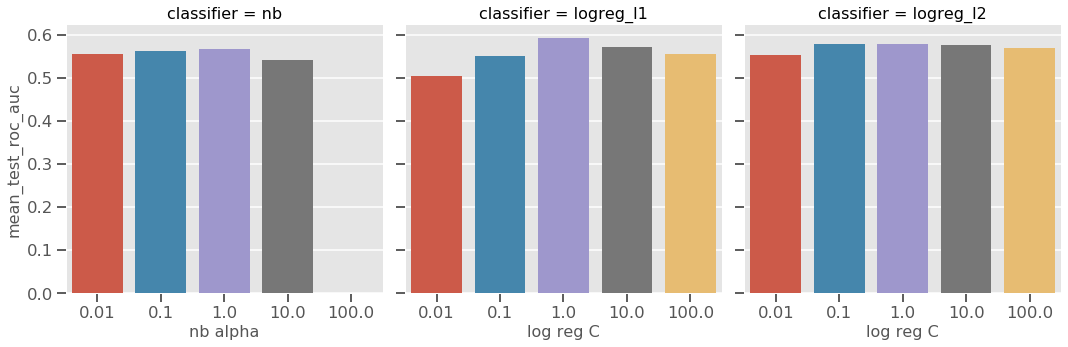

In [106]:
g = sns.catplot(x="classifier_params", col="classifier", y='mean_test_roc_auc', kind='bar', data=grid_cv_sum)
axs = g.axes
axs[0,0].set_xlabel('nb alpha')
axs[0,1].set_xlabel('log reg C')
axs[0,2].set_xlabel('log reg C')
plt.show()

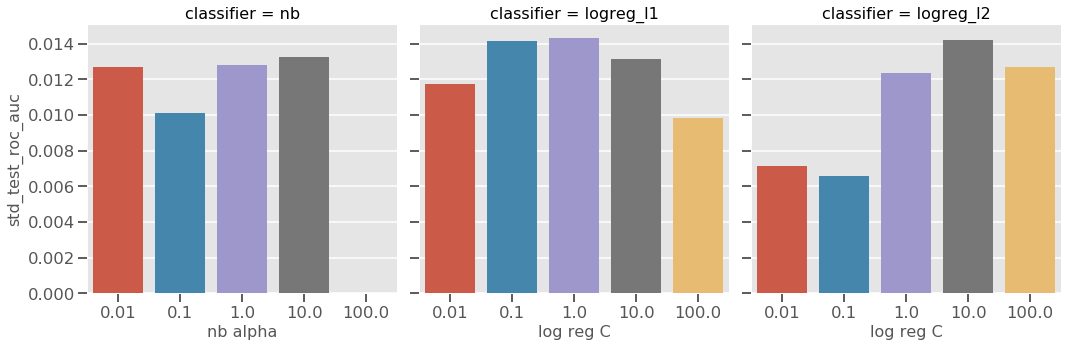

In [107]:
g = sns.catplot(x="classifier_params", col="classifier", y='std_test_roc_auc', kind='bar', data=grid_cv_sum)
axs = g.axes
axs[0,0].set_xlabel('nb alpha')
axs[0,1].set_xlabel('log reg C')
axs[0,2].set_xlabel('log reg C')
plt.show()

In [108]:
log_reg_l1_C = 100
model_mask = (grid_cv_sum['classifier']=='logreg_l1') & (grid_cv_sum['classifier__C']==log_reg_l1_C)

best_logreg_l1 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', C=log_reg_l1_C, max_iter=500).fit(X_train, y_train_c)
best_logreg_l1_mean_cv_auc = grid_cv_sum.loc[model_mask, 'mean_test_roc_auc'].iloc[0]

In [109]:
log_reg_l2_C = 0.1
model_mask = (grid_cv_sum['classifier']=='logreg_l2') & (grid_cv_sum['classifier__C']==log_reg_l2_C)

best_logreg_l2 = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='lbfgs', penalty='l2', C=log_reg_l2_C, max_iter=1000, n_jobs=-1).fit(X_train, y_train_c)
best_logreg_l2_mean_cv_auc = grid_cv_sum.loc[model_mask, 'mean_test_roc_auc'].iloc[0]

In [115]:
nbc_alpha = 0.1
model_mask = (grid_cv_sum['classifier']=='nb') & (grid_cv_sum['classifier__alpha']==nbc_alpha)

best_nbc = MultinomialNB(alpha=nbc_alpha).fit(X_train, y_train_c)
best_nbc_mean_cv_auc = grid_cv_sum.loc[model_mask, 'mean_test_roc_auc'].iloc[0]

In [116]:
# Select champion model: Select a high AUC model, that has the lowest std dev in CV-evaluation score. This is log-reg-l1 at C=100, which may not be a highly regularized model but beeing |L1| reg many words in vocabulary are
champ_mod = best_logreg_l1
champ_mod_mean_cv_auc = best_logreg_l1_mean_cv_auc

In [117]:
auc_plot_data = [(best_logreg_l1, '(champ) ' + f'best log-reg-l1 C={log_reg_l1_C:0.2f})', best_logreg_l1_mean_cv_auc ),
                 (best_logreg_l2, f'best log-reg-l2: C={log_reg_l2_C:0.2f}', best_logreg_l2_mean_cv_auc),
                 (best_nbc, fr'best naive-bayes: $\alpha={nbc_alpha:0.2f}$', best_nbc_mean_cv_auc),
                 (grid_cv_res.best_estimator_, 'highest score model', grid_cv_res.best_score_)]

mean_cv_auc_lst = [best_logreg_l2_mean_cv_auc, best_logreg_l1_mean_cv_auc, best_nbc_mean_cv_auc, grid_cv_res.best_score_]

## Model Interpration

In [118]:
champ_model_coefs = pd.Series(index=X_train.columns.tolist(), data=champ_mod.coef_.reshape(-1), name='coef')

In [119]:
n =len(champ_model_coefs)
n_shrinked = len(champ_model_coefs[champ_model_coefs==0])
shrinked_ratio = n_shrinked / n

In [120]:
print(f'Percentage of shrinked to 0 terms: {shrinked_ratio:0.2%} ({n_shrinked} out of {n})')

Percentage of shrinked to 0 terms: 32.44% (882 out of 2719)


In [121]:
champ_model_coefs_sent = champ_model_coefs.to_frame()
champ_model_coefs_sent['lou_sent'] = None
champ_model_coefs_sent['coef_positive'] = (champ_model_coefs_sent['coef'] >=0)
champ_model_coefs_sent['coef_abs'] = abs(champ_model_coefs_sent['coef'])
champ_model_coefs_sent['shrinked'] = (champ_model_coefs_sent['coef']==0)

for sentiment in sentiments:
    champ_model_coefs_sent['lou_sent'] = np.where(champ_model_coefs_sent.index.isin(sentiment_df.loc[sentiment_df[sentiment], 'word']), sentiment, champ_model_coefs_sent['lou_sent'])

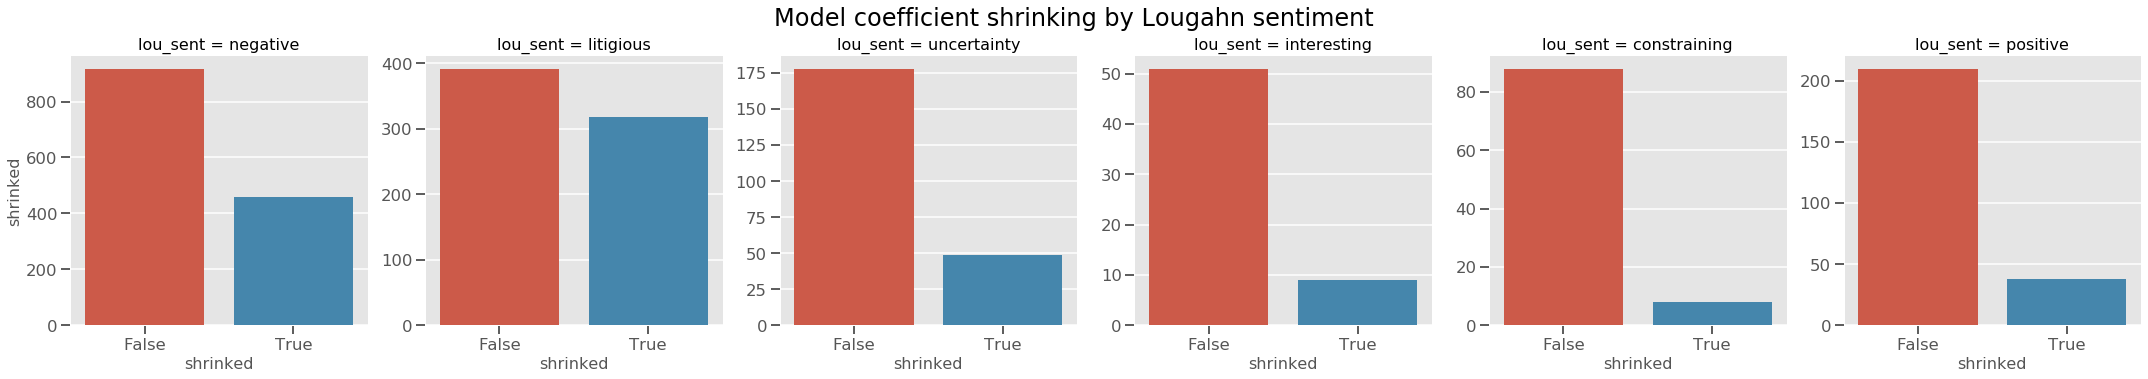

In [122]:
g = sns.catplot(x="shrinked", col="lou_sent", y='shrinked', kind='bar', estimator=np.size, data=champ_model_coefs_sent, sharey=False)

plt.suptitle('Model coefficient shrinking by Lougahn sentiment', y=1.05)
plt.show()

In [123]:
agg_champ_model_coefs_sent = champ_model_coefs_sent[champ_model_coefs_sent['coef']!=0].groupby('lou_sent')['coef'].describe()
agg_champ_model_coefs_sent

,count,mean,std,min,25%,50%,75%,max
lou_sent,,,,,,,,
constraining,88.0,-0.463359,13.514201,-59.953449,-2.539285,0.334278,4.741465,42.302766
interesting,51.0,4.290612,24.237111,-29.899165,-0.694712,0.858555,3.433047,157.227813
litigious,392.0,-0.170016,37.840822,-273.070838,-7.230003,0.388494,9.431511,186.674457
negative,918.0,-1.209211,30.555325,-155.686118,-9.435466,0.525664,9.442603,125.544450
positive,210.0,-0.036306,25.308694,-158.584023,-3.996063,0.289504,5.932463,213.409721
uncertainty,178.0,1.847488,27.550995,-100.695934,-7.226137,-0.446756,7.663507,139.666791


In [124]:
agg_sign_champ_model_coefs_sent = champ_model_coefs_sent[champ_model_coefs_sent['coef']!=0].groupby(['lou_sent', 'coef_positive'])['coef_abs'].describe()
agg_sign_champ_model_coefs_sent

count       mean        std       min       25%  \
lou_sent     coef_positive                                                    
constraining False           40.0   8.824053  13.753326  0.114868  0.967980   
             True            48.0   6.503886   8.487829  0.033087  1.220893   
interesting  False           16.0   7.773191   8.767063  0.040107  2.607744   
             True            35.0   9.805493  27.021726  0.029837  0.800159   
litigious    False          188.0  20.626545  37.424774  0.062161  2.399084   
             True           204.0  18.682079  26.891026  0.013042  2.621774   
negative     False          449.0  20.645697  26.564592  0.102604  3.278894   
             True           469.0  17.398428  21.080980  0.007532  3.921609   
positive     False          103.0  11.265675  22.857211  0.024941  1.646198   
             True           107.0  10.773274  22.797273  0.107487  2.238352   
uncertainty  False           92.0  13.225502  16.935125  0.085340  3.385264   
             True            86.0  17.972083  27.651682  0.012515  2.776264   

                                 50%        75%         max  
lou_sent     coef_positive                                   
constraining False          2.846581  10.616775   59.953449  
             True           4.212527   7.380524   42.302766  
interesting  False          5.154560   7.669937   29.899165  
             True           2.250046   5.957226  157.227813  
litigious    False          8.099681  21.821770  273.070838  
             True           8.555980  23.718267  186.674457  
negative     False          9.806925  27.604169  155.686118  
             True           9.209380  21.482719  125.544450  
positive     False          4.083706   9.947386  158.584023  
             True           5.782442  11.235068  213.409721  
uncertainty  False          7.137888  16.382780  100.695934  
             True           8.852957  19.817105  139.666791

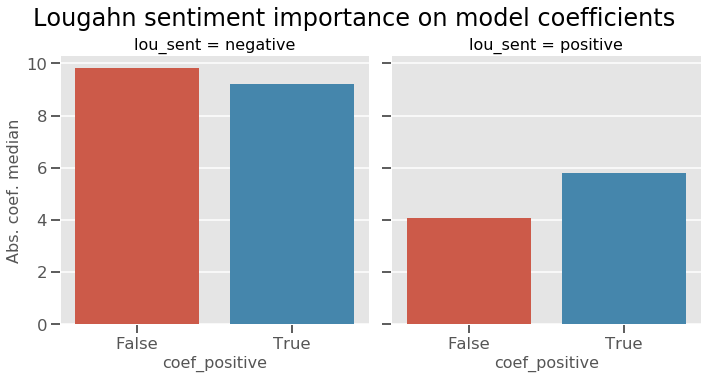

In [128]:
agg_sign_champ_model_coefs_sent_viz = agg_sign_champ_model_coefs_sent.reset_index().rename(columns={'50%': 'Abs. coef. median'}).\
    loc[agg_sign_champ_model_coefs_sent_viz['lou_sent'].isin(['positive','negative'])]

g = sns.catplot(x="coef_positive", col="lou_sent", y='Abs. coef. median', kind='bar', data=agg_sign_champ_model_coefs_sent_viz)

plt.suptitle('Lougahn sentiment importance on model coefficients', y=1.05)
plt.show()

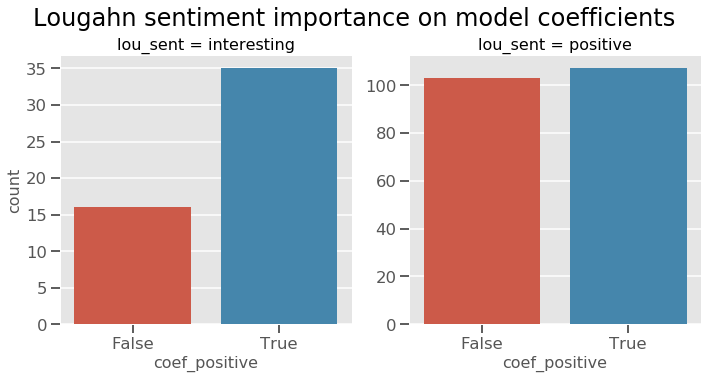

In [126]:
agg_sign_champ_model_coefs_sent_viz_subset = agg_sign_champ_model_coefs_sent_viz.loc[agg_sign_champ_model_coefs_sent_viz['lou_sent'].isin(['positive','interesting'])]

g = sns.catplot(x="coef_positive", col="lou_sent", y='count', kind='bar', data=agg_sign_champ_model_coefs_sent_viz_subset, sharey=False)

plt.suptitle('Lougahn sentiment importance on model coefficients', y=1.05)
plt.show()

Model limitations:

* There are only roughly 2 times more rows can columns, making it difficult to fit the model, there are two main caveats:
    * Curse of dimensionality: Having many features (in relation to the number of rows), makes model estimations less stable, there are other model approaches to this issue, like dimensionality reduction.
    * Sparsity: Document-term matrix have a lot of zeros, that's it, it is sparse. There are other representations that are denser, and also compile terms meaning (not only frequent co-ocurrence)
* On positive or negative sentiments, model importance is correctly matched, however, on other sentiments, they are not. That's it, median value of positive coefficients assigned to positive sentiment is higher than negative coeffcients. The same happens in negative. This may be due to vocabulary size (the larger the better). Other sentiments are missmatched.
* Nevertheless, there are no clear insights or differences from negative to positive medians.
* Approximatelly, a 35% of terms have been shrinked to zero.

## Assessment in test

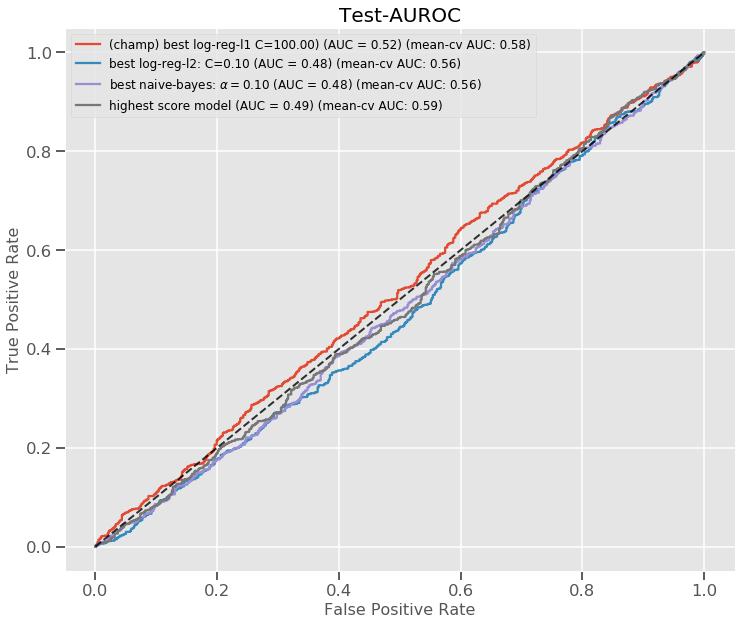

In [114]:
fig, ax = plt.subplots(1,1, figsize=(12, 10))

for i, row in enumerate(auc_plot_data):
    model, model_name, model_cv_score = row
    metrics.plot_roc_curve(model, X_test, y_test_c, ax=ax, name=model_name)
    #ax.text(1,0.15-i*0.05, f'{model_name}={model_score:0.2f}', va='bottom', ha='right')
    
handles, labels = ax.get_legend_handles_labels() 
labels = [f'{lab} (mean-cv AUC: {mean_cv_auc:0.2f})' for lab, mean_cv_auc in zip(labels, mean_cv_auc_lst)]
plt.legend(labels=labels)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black', label='Chance', alpha=.8)
plt.title("Test-AUROC")

plt.show()

In [130]:
grid_cv_sum.groupby('classifier')['mean_test_roc_auc'].apply(lambda x: np.sort(x)[-1])

classifier
logreg_l1    0.592816
logreg_l2    0.578313
nb           0.566016
Name: mean_test_roc_auc, dtype: float64

In [131]:
grid_cv_sum.sort_values(by=['classifier', 'rank_test_roc_auc']).groupby('classifier').first()

,classifier__alpha,classifier__C,classifier_params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc,idx
classifier,,,,,,,,,,,
logreg_l1,NaN,1.0,1.0,0.713834,0.579177,0.586638,0.612634,0.592816,0.014341,1,6
logreg_l2,NaN,1.0,1.0,0.696086,0.564116,0.576553,0.594270,0.578313,0.012373,2,11
nb,1.0,NaN,1.0,0.709458,0.548142,0.577409,0.572497,0.566016,0.012797,7,2


# Champion Model Predictions 

In [132]:
p_train = pd.Series(index=X_train.index, data=champ_mod.predict_proba(X_train)[:,1], name='sentiment_score')
p_test = pd.Series(index=X_test.index, data=champ_mod.predict_proba(X_test)[:,1], name='sentiment_score')

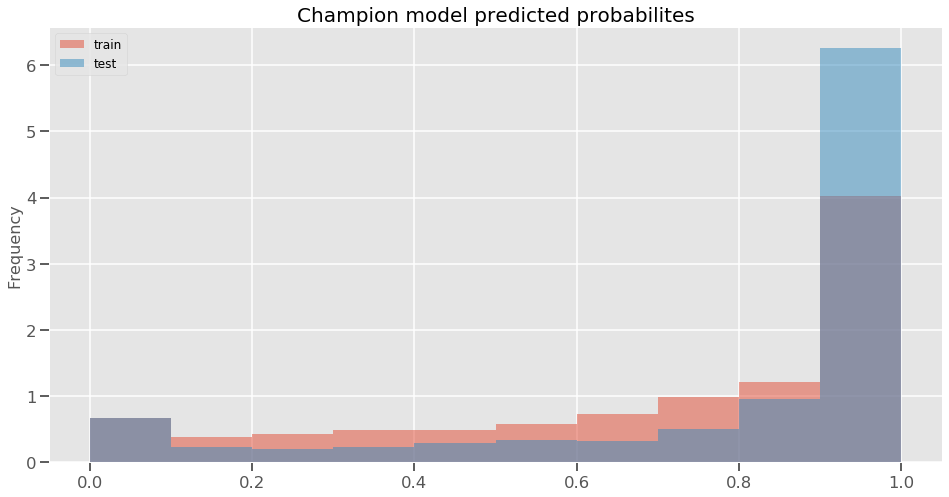

In [133]:
ax = p_train.plot.hist(density=True, alpha=0.5, label='train')
p_test.plot.hist(density=True, alpha=0.5, label='test', ax=ax)
plt.title("Champion model predicted probabilites")
plt.legend()
plt.show()

## From predictions to alpha factor

In [134]:
preds = pd.concat([p_train, p_test], axis=0).reset_index().merge(sector_to_asset, how='left', on='ticker').set_index(['date', 'ticker']).sort_index()
preds['sector_code'] = preds['sector_code'].fillna(-1)
preds['sector'] = preds['sector'].fillna("No sector")

In [135]:
sent_alphas = bow_sent.compute_sentiment_alpha_factor(sent_scores=preds, date_col='date', sector_col='sector_code', score_col='sentiment_score').\
    to_frame()
sent_alphas['split'] = splits
sent_alphas['date_filling'] = date_filling

sent_alphas = sent_alphas.sort_index()

pd.concat([pricing.head(2), pricing.tail(2)], axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEE,AEP,AES,AET,AFL,AGN,AIG,AIV,AIZ,AJG,AKAM,...,WBA,WDC,WEC,WFC,WHR,WM,WMB,WMT,WRK,WU,WY,WYN,WYNN,XEC,XEL,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-06,57.014,10.822,59.209,42.399,NaN,31.088,19.926,41.270,32.27,30.936,26.230,34.990,70.301,41.26,20.703,26.659,10.986,29.308,23.236,50.648,46.749,20.247,32.972,22.599,48.45,...,35.023,28.571,22.424,26.328,73.779,28.636,14.060,44.446,NaN,15.490,15.583,25.603,85.930,85.815,17.834,19.045,25.095,59.697,33.386,25.945,NaN,30.184,49.601,23.427,NaN
2011-01-07,57.495,10.976,60.790,42.702,NaN,31.150,20.009,41.338,32.04,30.756,26.445,35.070,70.026,40.76,20.703,26.555,10.986,29.371,23.145,51.440,47.314,20.088,32.596,22.458,48.69,...,34.814,28.589,22.594,25.796,73.468,28.479,14.283,44.545,NaN,15.346,16.011,25.509,88.972,87.296,17.993,19.010,24.954,60.023,33.251,25.583,NaN,30.560,49.592,23.182,NaN
2016-01-04,130.838,39.933,151.537,100.621,52.526,97.613,40.544,96.984,91.97,51.310,33.183,77.587,267.230,60.31,39.633,53.390,8.493,106.357,27.897,300.779,57.212,36.450,74.077,37.451,52.31,...,79.032,56.158,47.153,49.176,139.143,49.421,22.642,57.521,37.972,16.153,27.113,66.912,65.687,89.186,32.915,36.226,43.194,70.617,58.018,26.056,34.923,49.300,99.714,25.983,46.398
2016-01-05,131.369,39.552,150.502,98.100,52.307,99.041,40.534,97.489,92.34,50.933,33.553,77.776,269.531,60.39,40.103,53.829,8.611,107.837,27.859,302.012,57.410,37.378,75.313,37.553,52.02,...,76.958,55.916,47.659,49.157,136.146,49.610,22.720,58.887,37.947,16.089,27.177,67.441,66.929,89.761,33.247,36.302,43.836,71.218,59.201,26.005,34.913,49.177,101.790,25.701,47.124


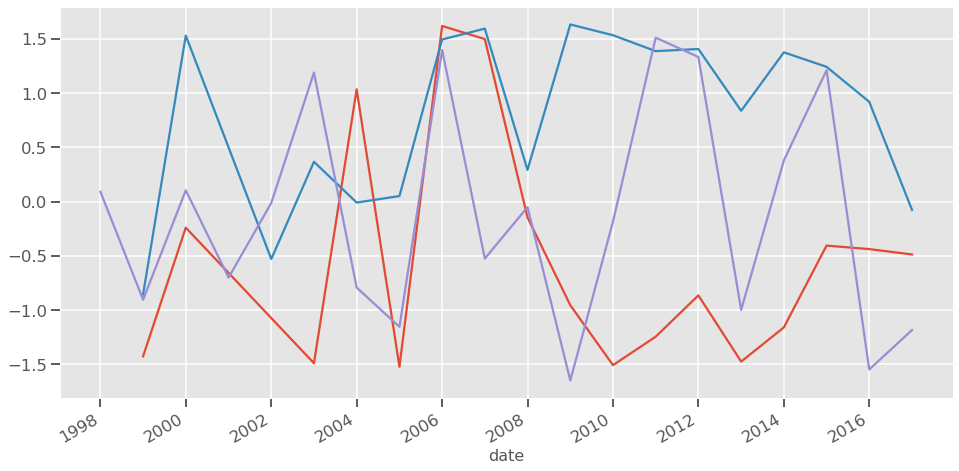

In [136]:
example = sent_alphas['sentiment_score']
ax = example.xs(key='amzn', level='ticker').plot()
example.xs(key='aapl', level='ticker').plot(ax=ax)
example.xs(key='msft', level='ticker').plot(ax=ax)
plt.show()

# Prediction Horizon Analysis

## Target: 20d

In [69]:
nbc_20d = MultinomialNB()

nbc_20d_cv1 = GridSearchCV(nbc_20d, {'alpha': alpha_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_20d_bin))
res_nbc_20d_cv1 = nbc_20d_cv1.fit(X_train_st, y_train_20d_bin)

In [70]:
logreg_20d = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', max_iter=500)

logreg_20d_cv1 = GridSearchCV(logreg_20d, {'C': c_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_20d_bin))
res_logreg_20d_cv1 = logreg_20d_cv1.fit(X_train_st, y_train_20d_bin)

In [71]:
pd.DataFrame(res_nbc_20d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'alpha': 0.01},0.561181,0.591503,0.497089,0.490469,0.526354,0.046147,3
1,{'alpha': 0.1},0.568565,0.599510,0.499262,0.489249,0.529340,0.049785,2
2,{'alpha': 1.0},0.565401,0.597426,0.508570,0.489290,0.531762,0.047094,1
3,{'alpha': 10.0},0.568565,0.557108,0.535632,0.473804,0.522181,0.035314,4


In [72]:
pd.DataFrame(res_logreg_20d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'C': 0.01},0.431435,0.500000,0.500000,0.500000,0.500000,0.000000,3
1,{'C': 0.1},0.566456,0.500980,0.476997,0.495468,0.491148,0.010257,5
2,{'C': 1.0},0.555907,0.579085,0.481384,0.503902,0.521457,0.041773,1
3,{'C': 10.0},0.528481,0.575327,0.456946,0.502622,0.511631,0.048747,2
4,{'C': 100.0},0.498945,0.556863,0.452313,0.489249,0.499475,0.043291,4


In [77]:
champ_model_20d = MultinomialNB(alpha=10).fit(X_train_st, y_train_20d_bin)

## Target: 5d

In [73]:
nbc_5d = MultinomialNB()

nbc_5d_cv1 = GridSearchCV(nbc_5d, {'alpha': alpha_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_5d_bin))
res_nbc_5d_cv1 = nbc_5d_cv1.fit(X_train_st, y_train_5d_bin)

In [74]:
logreg_5d = LogisticRegression(fit_intercept=False, random_state=RND_SEED, solver='liblinear', penalty='l1', max_iter=500)

logreg_5d_cv1 = GridSearchCV(logreg_5d, {'C': c_grid}, scoring=['accuracy', 'roc_auc'],
                        n_jobs=-1, refit='roc_auc',
                        cv=TimeSeriesSplit(n_splits=KFOLDS).split(y_train_5d_bin))
res_logreg_5d_cv1 = logreg_5d_cv1.fit(X_train_st, y_train_5d_bin)

In [75]:
pd.DataFrame(res_nbc_5d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'alpha': 0.01},0.561181,0.591503,0.497089,0.490469,0.526354,0.046147,3
1,{'alpha': 0.1},0.568565,0.599510,0.499262,0.489249,0.529340,0.049785,2
2,{'alpha': 1.0},0.565401,0.597426,0.508570,0.489290,0.531762,0.047094,1
3,{'alpha': 10.0},0.568565,0.557108,0.535632,0.473804,0.522181,0.035314,4


In [76]:
pd.DataFrame(res_logreg_5d_cv1.cv_results_).filter(regex='(params|auc|mean_test_accuracy)')

,params,mean_test_accuracy,split0_test_roc_auc,split1_test_roc_auc,split2_test_roc_auc,mean_test_roc_auc,std_test_roc_auc,rank_test_roc_auc
0,{'C': 0.01},0.431435,0.500000,0.500000,0.500000,0.500000,0.000000,3
1,{'C': 0.1},0.566456,0.500980,0.476997,0.495468,0.491148,0.010257,5
2,{'C': 1.0},0.555907,0.579085,0.481384,0.503902,0.521457,0.041773,1
3,{'C': 10.0},0.528481,0.575327,0.456946,0.502622,0.511631,0.048747,2
4,{'C': 100.0},0.498945,0.556863,0.452313,0.489249,0.499475,0.043291,4


## Short-Term alphas

In [109]:
champ_model_5d = MultinomialNB(alpha=10).fit(X_train_st, y_train_5d_bin)
champ_model_20d = MultinomialNB(alpha=10).fit(X_train_st, y_train_20d_bin)

In [141]:
p_train_5d = pd.Series(index=X_train_st.index, data=champ_model_5d.predict_proba(X_train_st)[:,1], name='sentiment_score')
p_test_5d = pd.Series(index=X_test_st.index, data=champ_model_5d.predict_proba(X_test_st)[:,1], name='sentiment_score')
preds_5d = pd.concat([p_train_5d, p_test_5d], axis=0).reset_index().merge(sector_to_asset, how='left', on='ticker').set_index(['date_filling', 'ticker']).sort_index()

In [142]:
p_train_20d = pd.Series(index=X_train_st.index, data=champ_model_20d.predict_proba(X_train_st)[:,1], name='sentiment_score')
p_test_20d = pd.Series(index=X_test_st.index, data=champ_model_20d.predict_proba(X_test_st)[:,1], name='sentiment_score')
preds_20d = pd.concat([p_train_20d, p_test_20d], axis=0).reset_index().merge(sector_to_asset, how='left', on='ticker').set_index(['date_filling', 'ticker']).sort_index()


In [143]:
date_idx = date_filling.reset_index().set_index(['date_filling', 'ticker'])
preds_5d = preds_5d.merge(date_idx, on=['date_filling', 'ticker'])
preds_5d['sector_code'] = preds_5d['sector_code'].fillna(-1)
preds_5d['sector'] = preds_5d['sector'].fillna("No sector")

pd.concat([preds_5d.head(2), preds_5d.tail(2)], axis=0)

,,sentiment_score,sector_code,sector,date
date_filling,ticker,,,,
2011-01-26,dfs,0.903179,5,Financial Services,2011-01-01
2011-01-27,adbe,0.945969,1,Technology,2011-01-01
2015-12-18,de,0.914544,3,Industrials,2015-01-01
2015-12-21,a,0.944229,0,Healthcare,2015-01-01


In [144]:
preds_5d[['sentiment_score']].describe().T

,count,mean,std,min,25%,50%,75%,max
sentiment_score,2142.0,0.929067,0.03442,0.583431,0.923919,0.936445,0.944307,0.960273


In [145]:
preds_20d = preds_20d.merge(date_idx, on=['date_filling', 'ticker'])
preds_20d['sector_code'] = preds_20d['sector_code'].fillna(-1)
preds_20d['sector'] = preds_20d['sector'].fillna("No sector")

pd.concat([preds_20d.head(2), preds_20d.tail(2)], axis=0)

,,sentiment_score,sector_code,sector,date
date_filling,ticker,,,,
2011-01-26,dfs,0.903179,5,Financial Services,2011-01-01
2011-01-27,adbe,0.945969,1,Technology,2011-01-01
2015-12-18,de,0.914544,3,Industrials,2015-01-01
2015-12-21,a,0.944229,0,Healthcare,2015-01-01


In [146]:
sent_alphas_5d = bow_sent.compute_sentiment_alpha_factor(sent_scores=preds_5d, date_col='date', sector_col='sector_code', score_col='sentiment_score').\
    to_frame().add_suffix('_5d')

pd.concat([sent_alphas_5d.head(2), sent_alphas_5d.tail(2)], axis=0)

,,sentiment_score_5d
date_filling,ticker,
2011-01-26,dfs,-0.954184
2011-01-27,adbe,0.713564
2015-12-18,de,-1.421571
2015-12-21,a,-0.148406


In [147]:
sent_alphas_20d = mle_utils.compute_sentiment_alpha_factor(sent_scores=preds_20d, date_col='date', sector_col='sector_code', score_col='sentiment_score').\
    to_frame().add_suffix('_20d')

pd.concat([sent_alphas_20d.head(2), sent_alphas_20d.tail(2)], axis=0)

,,sentiment_score_20d
date_filling,ticker,
2011-01-26,dfs,-0.954184
2011-01-27,adbe,0.713564
2015-12-18,de,-1.421571
2015-12-21,a,-0.148406


In [156]:
#sent_alphas = pd.read_csv(OUTPATH + OUTFILE1, parse_dates=['date', 'date_filling'], index_col=['date', 'ticker']).drop(columns=['sentiment_score_5d', 'sentiment_score_20d'])

sentiment_score  split date_filling
date       ticker                                     
1998-01-01 abt           -0.126626  train   1998-03-09
           adbe           0.904468  train   1998-02-17
           adi            0.072357  train   1998-01-28
           adm           -0.235162  train   1998-09-24
           adp           -0.198983  train   1998-09-23
...                            ...    ...          ...
2017-01-01 xyl           -0.913440   test   2017-02-23
           yum           -0.131597   test   2017-02-22
           zbh            0.000000   test   2017-03-01
           zion          -1.370159   test   2017-02-28
           zts            0.015482   test   2017-02-16

[7254 rows x 3 columns]

In [157]:
sent_alphas_20d_5d = sent_alphas_20d.join(sent_alphas_5d).join(date_idx).reset_index().set_index(['date', 'ticker'])
sent_alphas = sent_alphas.join(sent_alphas_20d_5d.drop(columns='date_filling'), how='left')

pd.concat([sent_alphas.head(2), sent_alphas.tail(2)], axis=0)

sentiment_score  split date_filling  sentiment_score_20d  \
date       ticker                                                             
1998-01-01 abt           -0.126626  train   1998-03-09                  NaN   
           adbe           0.904468  train   1998-02-17                  NaN   
2017-01-01 zion          -1.370159   test   2017-02-28                  NaN   
           zts            0.015482   test   2017-02-16                  NaN   

                   sentiment_score_5d  
date       ticker                      
1998-01-01 abt                    NaN  
           adbe                   NaN  
2017-01-01 zion                   NaN  
           zts                    NaN

# Write Data

In [137]:
if FLG_OUTPUT:
    sent_alphas.to_csv(OUTPATH + OUTFILE1)